In [ ]:
# подключаем диск
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install optuna seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.4/247.4 kB 23.2 MB/s eta 0:00:00


In [ ]:
import os
csv_path = "/content/drive/MyDrive/Colab Notebooks/raw/creditcard_1_02_00.csv"

## Попробуем LSTM, подбор гиперпараметров Optuna
- **помним про временные split, признаки и метрики те же**

## 1. Импорты


In [ ]:
import os, warnings, random, json, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.metrics import (precision_score, recall_score, f1_score,
                             roc_auc_score, precision_recall_curve, auc,
                             average_precision_score, confusion_matrix)
from sklearn.preprocessing import RobustScaler
from IPython.display import clear_output

import optuna
from optuna.samplers import TPESampler

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (8, 4)

# 2 фиксируем сиды
RANDOM_STATE = 42
def set_seed(seed=RANDOM_STATE):
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    np.random.seed(seed); random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


## 2. Загрузка

In [ ]:
df = pd.read_csv(csv_path)
print(f"\nРазмер данных: {df.shape[0]} строк, {df.shape[1]} столбцов")
print(f"Распределение классов:\n{df['Class'].value_counts(normalize=True)}")


Размер данных: 284807 строк, 35 столбцов
Распределение классов:
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


## 3.сплиты

In [ ]:
time_col = 'Time_abs_hour'
def get_train_test(df, col, train_finish, train_start=0, test_finish=0, gap=0):
    if test_finish == 0:
        test_finish = df[col].max()
    test_start = train_finish + gap + 1
    df_train = df[(df[col] >= train_start) & (df[col] <= train_finish)]
    df_test  = df[(df[col] >= test_start)  & (df[col] <= test_finish)]
    print(f"train: {df_train[col].min()}–{df_train[col].max()} | test: {df_test[col].min()}–{df_test[col].max()}")
    return df_train, df_test

train_finish = df[time_col].max() - 8
df_train, df_test = get_train_test(df, time_col, train_finish)

train_finish_2 = df_train[time_col].max() - 8
df_train_2, df_val = get_train_test(df_train, time_col, train_finish_2)

train: 0.0–39.0 | test: 40.0–47.0
train: 0.0–31.0 | test: 32.0–39.0


## 4. Признаки и целевая переменная

In [ ]:
unnecessary_cols = ['Time','Amount','Time_hour','Time_day','Amount_log', time_col]
target_col = 'Class'
drop_cols = [target_col] + unnecessary_cols

def xy(df):
    X = df.drop(drop_cols, axis=1).astype('float32').values
    y = df[target_col].values
    return X, y

X_tr,   y_tr   = xy(df_train_2)
X_val,  y_val  = xy(df_val)
X_test, y_test = xy(df_test)
X_train, y_train = xy(df_train)

# Определим n_features до objective
n_features = X_tr.shape[1]

## 5. Dataset

In [ ]:
# датасет с ленивым окном
from torch.utils.data import Dataset

class LazySeqDataset(Dataset):
    """
    Хранит только 2-D X и 1-D y.
    В __getitem__ формирует окно [idx : idx+seq_len] без копирования данных.
    """
    def __init__(self, X, y, seq_len):
        super().__init__()
        self.X = X           # (N, n_features)
        self.y = y           # (N,)
        self.seq_len = seq_len

    def __len__(self):
        return len(self.y) - self.seq_len + 1   # кол-во допустимых окон

    def __getitem__(self, idx):
        # Срез numpy не копирует память
        x_window = self.X[idx : idx + self.seq_len]   # (seq_len, n_features)
        y_target = self.y[idx + self.seq_len - 1]     # метка последнего шага
        return torch.tensor(x_window, dtype=torch.float32), \
               torch.tensor(y_target, dtype=torch.float32)

## 6. Модель LSTM

In [ ]:
class LSTMAnomaly(nn.Module):
    """
    Простая LSTM для бинарной классификации.
    Вход: (batch, seq_len, n_features)
    Выход: скаляр-логит
    """
    def __init__(self, n_features, hidden_size=64,
                 num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x: (B, seq_len, n_features)
        out, _ = self.lstm(x)           # (B, seq_len, hidden)
        last_out = out[:, -1, :]        # берём последний тайм-степ
        return self.fc(last_out).squeeze(-1)  # (B,)

## 7. Функция потерь и метрика

In [ ]:
class PR_AUC_Metric:
    def __init__(self):
        self._name = "pr_auc"
        self._maximize = True
    def __call__(self, y_true, y_score):
        return average_precision_score(y_true, y_score)

loss_fn = nn.BCEWithLogitsLoss(
    pos_weight=torch.tensor([len(y_tr)/y_tr.sum()], device=device)
    )

## 8. Optuna — подбор гиперпараметров

In [ ]:
def objective(trial):
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [128, 256])
    hidden_size = trial.suggest_int("hidden_size", 32, 128, step=32)
    num_layers = trial.suggest_int("num_layers", 1, 5)
    dropout = trial.suggest_float("dropout", 0.0, 0.3)
    # seq_len = trial.suggest_int("seq_len", 1, 200)
    seq_len = trial.suggest_int("seq_len", 1, 400, log=True)

    print('\ntrial started with :')
    print(f' batch_size = {batch_size}, hidden_size = {hidden_size},\n num_layers = {num_layers}, seq_len = {seq_len},\n lr = {lr}, dropout = {dropout}')

    model = LSTMAnomaly(
        n_features = n_features,
        hidden_size=hidden_size,
        num_layers=num_layers,
        dropout=dropout
    ).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1)


    # 1. DataLoader, который делает окна «на лету»
    tr_ds = LazySeqDataset(X_tr, y_tr, seq_len=seq_len)
    val_ds = LazySeqDataset(X_val, y_val, seq_len=seq_len)

    tr_loader = torch.utils.data.DataLoader(
        tr_ds, batch_size=batch_size, shuffle=True, drop_last=True
    )
    val_loader = torch.utils.data.DataLoader(
        val_ds, batch_size=batch_size, shuffle=False, drop_last=False
    )

    best_pr_auc = 0.0
    patience, counter = 5, 0

    for epoch in range(50):
        # --- train ---
        model.train()
        for X, y in tr_loader:  # X: (B, seq_len, n_features)
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            loss = loss_fn(model(X), y)
            loss.backward()
            optimizer.step()
        scheduler.step()

        # --- eval ---
        model.eval()
        preds, labels = [], []
        with torch.no_grad():
            for X, y in val_loader:
                X = X.to(device)
                logits = model(X)           # (B,)
                preds.append(torch.sigmoid(logits).cpu())
                labels.append(y)
        preds = torch.cat(preds).numpy()
        labels = torch.cat(labels).numpy()
        pr_auc = average_precision_score(labels, preds)

        if pr_auc > best_pr_auc + 1e-4:
            best_pr_auc = pr_auc
            counter = 0
        else:
            counter += 1
        if counter >= patience:
            break
    print(f"\nУчились {epoch} эпох.")
    return best_pr_auc


set_seed()


n_trials=15

# SEQ_LEN = 20
# tr_ds = LazySeqDataset(X_tr, y_tr, seq_len=SEQ_LEN)
# val_ds = LazySeqDataset(X_val, y_val, seq_len=SEQ_LEN)

study = optuna.create_study(direction="maximize", sampler=TPESampler(seed=RANDOM_STATE))
study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

print("Best trial:", study.best_trial.params)
print("Best PR-AUC:", study.best_value)

[I 2025-09-01 09:15:38,405] A new study created in memory with name: no-name-f715a1e8-a10d-4f73-8fdb-ab848b8b40ef


  0%|          | 0/15 [00:00<?, ?it/s]


trial started with :
 batch_size = 128, hidden_size = 96,
 num_layers = 1, seq_len = 1,
 lr = 5.6115164153345e-05, dropout = 0.04679835610086079

Учились 10 эпох.
[I 2025-09-01 09:17:07,717] Trial 0 finished with value: 0.7627574298691538 and parameters: {'lr': 5.6115164153345e-05, 'batch_size': 128, 'hidden_size': 96, 'num_layers': 1, 'dropout': 0.04679835610086079, 'seq_len': 1}. Best is trial 0 with value: 0.7627574298691538.

trial started with :
 batch_size = 256, hidden_size = 32,
 num_layers = 5, seq_len = 2,
 lr = 0.0005399484409787432, dropout = 0.2497327922401265

Учились 16 эпох.
[I 2025-09-01 09:19:05,061] Trial 1 finished with value: 0.7373496052949597 and parameters: {'lr': 0.0005399484409787432, 'batch_size': 256, 'hidden_size': 32, 'num_layers': 5, 'dropout': 0.2497327922401265, 'seq_len': 2}. Best is trial 0 with value: 0.7627574298691538.

trial started with :
 batch_size = 256, hidden_size = 96,
 num_layers = 3, seq_len = 30,
 lr = 2.3102018878452926e-05, dropout = 

In [ ]:
# optuna визуализация
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()
optuna.visualization.plot_parallel_coordinate(study).show()

## 9. Обучение финальной модели

In [ ]:
def train_with_plot_and_scheduler(model, train_loader, val_loader, optimizer, criterion, epochs):

    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1)

    train_losses = []
    val_losses = []
    pr_aucs = []
    roc_aucs = []
    lrs = []

    for epoch in range(epochs):
        model.train()  # настраиваем на обучение
        total_loss, n = 0., 0  # задаём стартовые значения
        for X, y in train_loader:
            X, y = X.to(device), y.float().to(device)
            optimizer.zero_grad()    # обнуляем градиенты
            preds = model(X)  # prediction
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()
            # собираем результат в кучку
            total_loss += loss.item() * len(X)
            n += len(X)
        # среднее за эпоху
        train_loss = total_loss / n

        #
        model.eval()  # режим оценки
        # стартовая инициализация
        total_loss, n = 0., 0
        all_preds, all_labels = [], []

        for X, y in val_loader:
            X, y = X.to(device), y.float().to(device)
            with torch.no_grad():
                preds = torch.sigmoid(model(X))
            total_loss += criterion(preds, y).item() * len(X)
            n += len(X)
            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())

        preds = torch.cat(all_preds).numpy()
        labels = torch.cat(all_labels).numpy()
        pr_auc = auc(*precision_recall_curve(labels, preds)[1::-1])
        roc_auc = roc_auc_score(labels, preds)
        val_loss = total_loss / n


        train_losses.append(train_loss)
        val_losses.append(val_loss)
        pr_aucs.append(pr_auc)
        roc_aucs.append(roc_auc)
        lrs.append(optimizer.param_groups[0]['lr'])

        scheduler.step()  # обновляем learning rate

        # Обновление графика
        clear_output(wait=True)
        plt.figure(figsize=(15, 5))

        # Потери
        plt.subplot(1, 3, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss по эпохам')
        plt.legend()
        plt.xlim(0, epochs)

        # Метрики
        plt.subplot(1, 3, 2)
        plt.plot(pr_aucs, label='PR AUC')
        plt.plot(roc_aucs, label='ROC AUC')
        plt.xlabel('Epoch')
        plt.ylabel('Score')
        plt.title('Тест Metrics')
        plt.legend()
        plt.xlim(0, epochs)

        # Learning Rate
        plt.subplot(1, 3, 3)
        plt.plot(lrs, label='Learning Rate')
        plt.xlabel('Epoch')
        plt.ylabel('LR')
        plt.title('Learning Rate Decay')
        plt.legend()
        plt.xlim(0, epochs)

        plt.tight_layout()
        plt.show()

        print(f"Эпоха {epoch+1}/{epochs} — Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, PR AUC: {pr_auc:.4f}, ROC AUC: {roc_auc:.4f}, LR: {lrs[-1]:.6f}")


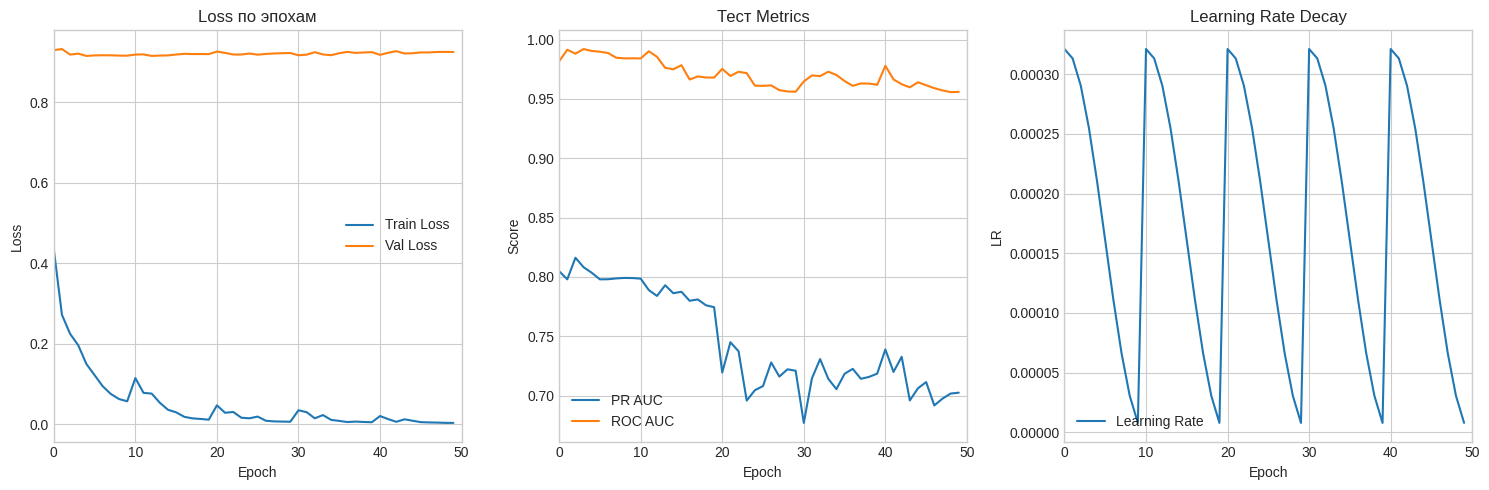

Эпоха 50/50 — Train Loss: 0.0031, Val Loss: 0.9253, PR AUC: 0.7024, ROC AUC: 0.9560, LR: 0.000008


In [ ]:
set_seed()
best = study.best_trial.params
model = LSTMAnomaly(
    n_features=n_features,
    hidden_size=best["hidden_size"],
    num_layers=best["num_layers"],
    dropout=best["dropout"]
).to(device)

seq_len = best['seq_len']

train_ds = LazySeqDataset(X_train, y_train, seq_len=seq_len)
test_ds = LazySeqDataset(X_test, y_test, seq_len=seq_len)

optimizer = torch.optim.AdamW(model.parameters(), lr=best["lr"])
train_with_plot_and_scheduler(
    model,

    train_loader = torch.utils.data.DataLoader(
        train_ds, batch_size=best["batch_size"], shuffle=True, drop_last=True
    ),
    val_loader = torch.utils.data.DataLoader(
        test_ds, batch_size=best["batch_size"], shuffle=False, drop_last=False
    ),
    optimizer=optimizer,
    criterion=loss_fn,
    epochs=50
)

## 10. Оценка на тесте

In [ ]:
test_loader = torch.utils.data.DataLoader(
        test_ds, batch_size=best["batch_size"], shuffle=False, drop_last=False
    )

# 2) собираем предсказания батчами
model.eval()
all_scores, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)                # (B, seq_len, n_features)
        logits = model(xb)                # (B,)
        scores = torch.sigmoid(logits).cpu()
        all_scores.append(scores)
        all_labels.append(yb)

y_score = torch.cat(all_scores).numpy()
y_true  = torch.cat(all_labels).numpy()
y_pred = (y_score >= 0.5).astype(int)
print("Порог детекции аномалий 0,5")
print("Test PR-AUC:", average_precision_score(y_true, y_score))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:",    recall_score(y_true, y_pred))
print("F1:",        f1_score(y_true, y_pred))


# 3) подбор порога по валидации (то же самое)
val_ds = LazySeqDataset(X_val, y_val, seq_len=best["seq_len"])
val_loader = torch.utils.data.DataLoader(
        val_ds, batch_size=best["batch_size"], shuffle=False, drop_last=False
    )
model.eval()
val_scores, val_labels = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        scores = torch.sigmoid(model(xb)).cpu()
        val_scores.append(scores)
        val_labels.append(yb)
val_score = torch.cat(val_scores).numpy()
val_labels = torch.cat(val_labels).numpy()

prec, rec, thr = precision_recall_curve(val_labels, val_score)
f1_scores = 2 * prec * rec / (prec + rec + 1e-12)
best_thr = thr[np.nanargmax(f1_scores)]
print("\nПосле поиска порога на val")
print(f"Оптимальный порог по val: {best_thr:.7f}")

# 4) финальные метрики
y_pred = (y_score >= best_thr).astype(int)
print("Test PR-AUC:", average_precision_score(y_true, y_score))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:",    recall_score(y_true, y_pred))
print("F1:",        f1_score(y_true, y_pred))

Порог детекции аномалий 0,5
Test PR-AUC: 0.706612585151556
Precision: 0.6896551724137931
Recall: 0.7792207792207793
F1: 0.7317073170731707

После поиска порога на val
Оптимальный порог по val: 0.9957641
Test PR-AUC: 0.706612585151556
Precision: 0.8769230769230769
Recall: 0.7402597402597403
F1: 0.8028169014084507


## 11. Подбор порога по валидации

## 12. Финальные метрики и визуализация

Test (порог подобран по валидации) PR-AUC=0.7024 Precision=0.877 Recall=0.740 F1=0.803


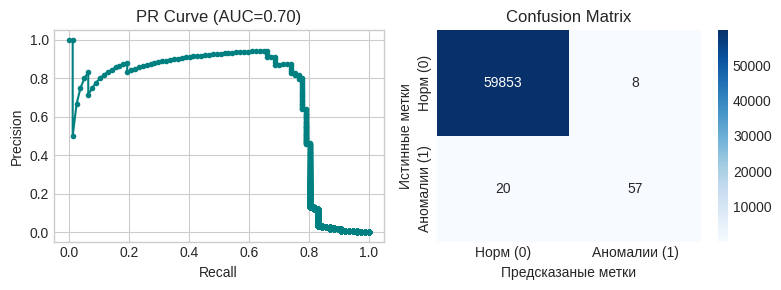

In [ ]:
precision =  precision_score(y_true, y_pred)
recall    = recall_score(y_true, y_pred)
f1        = f1_score(y_true, y_pred)
prec, rec, _ = precision_recall_curve(y_true, y_score)
pr_auc = auc(rec, prec)

print("Test (порог подобран по валидации) "
      f"PR-AUC={pr_auc:0.4f} Precision={precision:0.3f} Recall={recall:0.3f} F1={f1:.3f}")

# визуализация
labels = ['Норм (0)', 'Аномалии (1)']
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
axs[0].plot(rec, prec, marker='.', color='teal')
axs[0].set_xlabel("Recall"); axs[0].set_ylabel("Precision")
axs[0].set_title(f"PR Curve (AUC={pr_auc:.2f})")

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axs[1])
axs[1].set_xlabel("Предсказаные метки"); axs[1].set_ylabel("Истинные метки")
axs[1].set_title("Confusion Matrix")
plt.tight_layout(); plt.show()

## 14. Выводы
**Датасет**
- **Объём**: 284 807 транзакций, 35 признаков.
- **Ну очень сильный дисбаланс**: 0,17% транзакций — мошеннические (Class == 1).

**Временное разбиение**: данные разделены по `Time_abs_hour`:
  - **Train**: 0–39 часов (224 865 строк).  
  - **Test**: 40–47 часов (59 942 строк).
  
**Модель**  
- **LSTM**
  
**Подбор гиперпараметров**
- **Optuna**
  
**Метрики**  | F1   | PR AUC |
- **Test**     | 0.80 | 0.70   |

**Вывод**
- Модель справилась с задачей детекции аномалий троху хуже чем остальные.
не было возможности полноценно использовать данные по времени(как и с rolling statistic) они не улучшили ситуацию...
- - PR-AUC: 0.70 — низковат (из-за провала precision при высоком порге отсечения).
- -  Precision: 0.88, Recall: 0.74, F1: 0.80 — при пороге 0.9999499, подобранном на валидации достаточно не плох, если бы данные были разделены по картам и пользователям - результат был бы значительно выше
- Подбор гиперпараметров через Optuna был не очень эффективен.
- Модель переобучилась на val-выборку , хотя в целом справилась с дисбалансом классов (0.17% аномалий)
- Подбор порога классификации - важен: Исходно модель с порогом 0.5 давала  Recall (0.78) ,  Precision (0.69) и F1(0.73).  Последующий подбор оптимального порога  на валидационной выборке позволил  значительно улучшить F1-меру.